# Importing the packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread , imresize
import os
import time

# Parameters

In [30]:
no_latent = 10
lr = 1e-3
epochs = 100
batch_size = 5000

# Declaring functions

In [6]:
# Sigmoid

def sigmoid(x):
    return 1/(1 + np.exp(-x))

#derivative of sigmoid
def deriv_sigmoid(x):
    return np.exp(-x)/((1+ np.multiply(np.exp(-x),np.exp(-x))))

# softmax

def softmax(x):
    out = np.zeros(x.shape)
    for i in range(0,x.shape[0]):
        for j in range(0,x.shape[1]):
            out[i,j] = np.exp(x[i,j])/np.sum(np.exp(x[i]))
    return out

# sum of Squared error

def squared_error(y_train, y_predicted):
    return np.sum(np.multiply(y_train - y_predicted , y_train - y_predicted))

In [7]:
def load_flattened_images(Loc):
    Images = []
    for root, dirs, files in os.walk(Loc):
        for file in files:
            Image = imread(os.path.join(root, file))
            Image = Image / 255.0
            Images.append(Image.flatten())
                
    Images = np.asmatrix(Images)
    print(Images.shape)

    return Images

In [34]:
## fitting the model

def net_fit_vae(x_t , y_t , epochs = 100 , no_latent = 10 , lr = 1e-3 , batch_size = 5000):
    input_dim = x_t.shape[1]
    training_samples = x_t.shape[0]
    output_dim = y_t.shape[1]
    costs = []
    x_t = np.hstack((np.ones((training_samples , 1)), x_t))
    #initializig the parameters
    alpha = np.asmatrix(np.random.normal(0,1e-5,(input_dim + 1 , no_latent)))
    gaama = np.asmatrix(np.random.normal(0,1e-5,(input_dim + 1 , no_latent)))
    beta = np.asmatrix(np.random.normal(0,1e-5,(no_latent+1 , output_dim)))
    
    #looping for number of itretions
    for epoch in range(0,epochs):
        for i in range(0,int(training_samples/batch_size)):
            x_train = x_t[i*batch_size:(i+1)*batch_size , :]
            y_train = y_t[i*batch_size:(i+1)*batch_size , :]
            mu_raw = x_train * alpha
            mu = sigmoid(mu_raw)
            sigma_raw = x_train * gaama
            sigma = sigmoid(sigma_raw)

            #finding z matrix
            epsilon = (np.repeat(np.asmatrix(np.random.multivariate_normal(np.zeros((no_latent)) , np.eye(no_latent))), batch_size,axis = 0))
            z = np.multiply( epsilon, np.exp(0.5*sigma))+mu
            z_biased = np.asmatrix(np.hstack((np.ones((batch_size,1)),z)))

            #finding y matrix
            y_raw = z_biased * beta
            y_predicted = sigmoid(y_raw)

            ##finding the cost
            cost = squared_error(y_train , y_predicted) + 0.5*(np.sum(np.square(mu)) + np.sum(np.exp(sigma)) - np.sum(sigma) - no_latent*batch_size)
            costs.append(cost)
            #finding gradient w.r.t beta
            delta = np.multiply((y_predicted - y_train), deriv_sigmoid(y_raw))
            d_beta = z_biased.T * delta

            temp_beta = beta[1:,:]

            #finding gradient w.r.t alpha
            ss_alpha = np.multiply((delta * temp_beta.T),deriv_sigmoid(mu_raw))
            d_alpha = x_train.T * (ss_alpha + np.multiply(mu , deriv_sigmoid(mu_raw)))

            #finding gradient w.r.t gaama
            ss_beta = np.multiply((delta * temp_beta.T),deriv_sigmoid(sigma_raw))
            d_gaama = x_train.T * 0.5*( - 1* np.multiply(epsilon , np.multiply(ss_beta , np.exp(0.5 * sigma))) + np.multiply(np.exp(sigma) , deriv_sigmoid(sigma_raw)) - deriv_sigmoid(sigma_raw))

            #updating the weights
            beta = beta - lr * d_beta
            alpha = alpha - lr*d_alpha
            gaama = gaama - lr*d_gaama
#         print(np.max(alpha) , np.max(beta) , np.min(alpha) , np.min(beta))
            print("\nEpoch: " + str(epoch+1) + "   batch : " + str(i+1) + "   cost : " + str(cost))
    return beta , costs

In [80]:
#prediction

def net_generate(number , weights , no_latent):
    generated = []
    for i in range(0,number):
        x = np.asmatrix(np.random.multivariate_normal(np.zeros((no_latent)) , np.eye(no_latent)))
        x = np.asmatrix(np.hstack(([[1]],x)))
        gen = sigmoid(x * weights)
        gen_image = np.round(gen.reshape(28,28))
        generated.append(gen_image)
    return generated

# Generating training data

In [89]:
# x_train = load_flattened_images("/home/snehith/Documents/machine learning/datasets/mnist/mnistasjpg/testSet/")
# np.save("train_set_vae.npy" , x_train)
x_train = np.asmatrix(np.load("train_set_vae.npy"))
print(x_train.shape)

(28000, 784)


# Training the Model

In [35]:
# alpha , beta , losses = net_fit(x_Train , y_train_and , hidden_nodes = hidden_nodes , epochs = epochs ,lr = lr)
tic = time.time()
weights , lossses = net_fit_vae(x_train , x_train , no_latent = no_latent , epochs = epochs ,lr = lr)
print("time taken: "+ str(time.time() - tic) + "sec")
# print("\nalpha:\n",alpha ,"\nbeta:\n", beta,"\n" ,"\nloss:\n", losses[epochs-1])
np.save("weights_vae.npy" , weights)
# np.save("beta_weights_vae.npy" , beta)


Epoch: 1   batch : 1   cost : 894881.5249358417

Epoch: 1   batch : 2   cost : 1676604.399344305

Epoch: 1   batch : 3   cost : 836585.4236027156

Epoch: 1   batch : 4   cost : 2236734.8544620196

Epoch: 1   batch : 5   cost : 347814.4512032438

Epoch: 2   batch : 1   cost : 317521.29779653245

Epoch: 2   batch : 2   cost : 509330.21611798066

Epoch: 2   batch : 3   cost : 354953.83838184056

Epoch: 2   batch : 4   cost : 3169763.9514268045

Epoch: 2   batch : 5   cost : 2167246.5699105226

Epoch: 3   batch : 1   cost : 2432599.972278135

Epoch: 3   batch : 2   cost : 371774.3044271679

Epoch: 3   batch : 3   cost : 3148258.8589601796

Epoch: 3   batch : 4   cost : 299496.00505048194

Epoch: 3   batch : 5   cost : 351601.627779848

Epoch: 4   batch : 1   cost : 375597.57715359563

Epoch: 4   batch : 2   cost : 349980.09691169363

Epoch: 4   batch : 3   cost : 3055150.5294021782

Epoch: 4   batch : 4   cost : 1405978.3770361503

Epoch: 4   batch : 5   cost : 506721.0524602135

Epoch: 5


Epoch: 33   batch : 5   cost : 361837.32077460916

Epoch: 34   batch : 1   cost : 375469.3474709418

Epoch: 34   batch : 2   cost : 385187.74681602366

Epoch: 34   batch : 3   cost : 384486.2245251813

Epoch: 34   batch : 4   cost : 369785.78630550584

Epoch: 34   batch : 5   cost : 384684.8208451181

Epoch: 35   batch : 1   cost : 364403.0136873008

Epoch: 35   batch : 2   cost : 369956.7231989068

Epoch: 35   batch : 3   cost : 372300.2909645963

Epoch: 35   batch : 4   cost : 370976.0197647894

Epoch: 35   batch : 5   cost : 363825.97150601

Epoch: 36   batch : 1   cost : 419132.2380083096

Epoch: 36   batch : 2   cost : 396456.8574731221

Epoch: 36   batch : 3   cost : 456435.9380035514

Epoch: 36   batch : 4   cost : 368838.9684825259

Epoch: 36   batch : 5   cost : 378171.69561898184

Epoch: 37   batch : 1   cost : 371741.6006649504

Epoch: 37   batch : 2   cost : 365715.6259041299

Epoch: 37   batch : 3   cost : 477908.9802839797

Epoch: 37   batch : 4   cost : 374487.947693845


Epoch: 66   batch : 3   cost : 381837.24768361985

Epoch: 66   batch : 4   cost : 376291.81857381016

Epoch: 66   batch : 5   cost : 370714.4714561359

Epoch: 67   batch : 1   cost : 408073.229049813

Epoch: 67   batch : 2   cost : 385982.20596246753

Epoch: 67   batch : 3   cost : 374924.70562269783

Epoch: 67   batch : 4   cost : 393002.66844454466

Epoch: 67   batch : 5   cost : 380553.0014476797

Epoch: 68   batch : 1   cost : 390624.39093751065

Epoch: 68   batch : 2   cost : 385634.0037266076

Epoch: 68   batch : 3   cost : 382254.7364555289

Epoch: 68   batch : 4   cost : 407989.168785062

Epoch: 68   batch : 5   cost : 410079.501117883

Epoch: 69   batch : 1   cost : 386104.83163251326

Epoch: 69   batch : 2   cost : 383112.9515129432

Epoch: 69   batch : 3   cost : 388774.91895711084

Epoch: 69   batch : 4   cost : 392219.2531165233

Epoch: 69   batch : 5   cost : 386697.1155522425

Epoch: 70   batch : 1   cost : 376610.75910581654

Epoch: 70   batch : 2   cost : 384691.03191


Epoch: 99   batch : 1   cost : 381995.174765198

Epoch: 99   batch : 2   cost : 392830.6962310641

Epoch: 99   batch : 3   cost : 372973.6015363721

Epoch: 99   batch : 4   cost : 385830.7161260835

Epoch: 99   batch : 5   cost : 390707.27737520763

Epoch: 100   batch : 1   cost : 381133.7317133874

Epoch: 100   batch : 2   cost : 382274.33306743356

Epoch: 100   batch : 3   cost : 394116.710108392

Epoch: 100   batch : 4   cost : 379346.7504260815

Epoch: 100   batch : 5   cost : 399816.61837643705
time taken: 281.8900511264801sec


### Generating new images

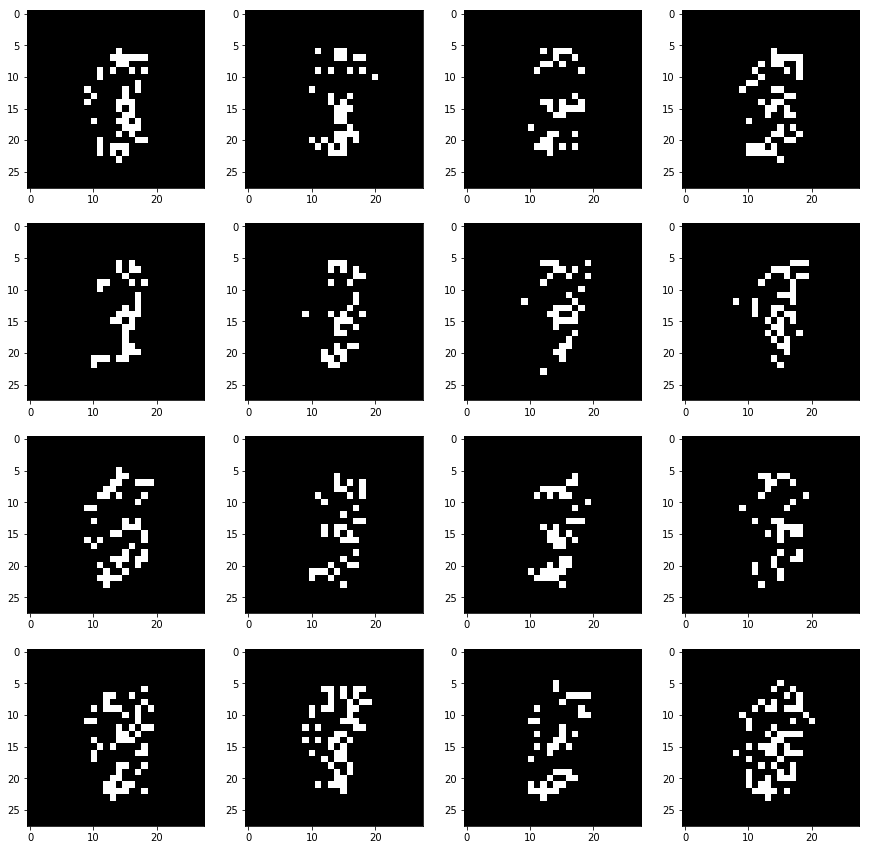

In [81]:
#Generating new images
result = net_generate(16 , weights , no_latent)
plt.figure(figsize = (15,15))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(result[i] , cmap = 'gray')

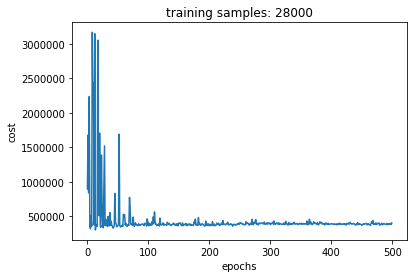

In [37]:
#ploting the cost vs epochs
plt.plot(np.arange(len(lossses)),lossses)
plt.title("training samples: " + str(x_train.shape[0]))
plt.xlabel("epochs")
plt.ylabel("cost")
plt.show()